# sts_inpr_q

In [1]:
import requests, pandas as pd
from itertools import product
from tabulate import tabulate

dataset = 'sts_inpr_q'
url = f"https://ec.europa.eu/eurostat/api/dissemination/statistics/1.0/data/{dataset}?format=JSON"
response = requests.get(url)
if response.status_code == 200:
    data = response.json()
    # print("- ✅ Connessione riuscita.")
    print("- 📦 Chiavi:", data.keys(), "\n")
    print("- 📐 Dimensioni disponibili:", data["dimension"].keys(), "\n")
    print("- 🔢 Numero di valori:", len(data["value"]), "\n")
else:
    print("❌ Errore:", response.status_code)
    print(response.text)

- 📦 Chiavi: dict_keys(['version', 'class', 'label', 'source', 'updated', 'value', 'status', 'id', 'size', 'dimension', 'extension']) 

- 📐 Dimensioni disponibili: dict_keys(['freq', 'indic_bt', 'nace_r2', 's_adj', 'unit', 'geo', 'time']) 

- 🔢 Numero di valori: 4043318 



In [2]:
def parse_eurostat_data(data):
    dimensions = data["dimension"]
    
    # Etichette delle dimensioni
    freq_labels   = dimensions["freq"]["category"]["label"]
    indic_labels  = dimensions["indic_bt"]["category"]["label"]
    nace_labels   = dimensions["nace_r2"]["category"]["label"]
    s_adj_labels  = dimensions["s_adj"]["category"]["label"]
    unit_labels   = dimensions["unit"]["category"]["label"]
    geo_labels    = dimensions["geo"]["category"]["label"]
    time_labels   = dimensions["time"]["category"]["label"]
    
    # Chiavi (codici) per ciascuna dimensione
    freq_keys  = list(freq_labels.keys())
    indic_keys = list(indic_labels.keys())
    nace_keys  = list(nace_labels.keys())
    s_adj_keys = list(s_adj_labels.keys())
    unit_keys  = list(unit_labels.keys())
    geo_keys   = list(geo_labels.keys())
    time_keys  = list(time_labels.keys())

    # Combinazioni
    combinations = list(product(freq_keys, indic_keys, nace_keys, s_adj_keys, unit_keys, geo_keys, time_keys))
    
    # Costruzione record
    records = []
    for i, (f, ind, nac, sa, u, g, t) in enumerate(combinations):
        if str(i) in data["value"]:
            records.append({
                "freq_code": f,
                "freq_label": freq_labels[f],
                "indic_bt_code": ind,
                "indic_bt_label": indic_labels[ind],
                "nace_r2_code": nac,
                "nace_r2_label": nace_labels[nac],
                "s_adj_code": sa,
                "s_adj_label": s_adj_labels[sa],
                "unit_code": u,
                "unit_label": unit_labels[u],
                "geo_code": g,
                "geo_label": geo_labels[g],
                "time_code": t,
                "time_label": time_labels[t],
                "value": data["value"][str(i)]
            })
    
    return pd.DataFrame(records)


In [3]:
df = parse_eurostat_data(data)
(df.head())

,freq_code,freq_label,indic_bt_code,indic_bt_label,nace_r2_code,nace_r2_label,s_adj_code,s_adj_label,unit_code,unit_label,geo_code,geo_label,time_code,time_label,value
0,Q,Quarterly,PRD,Production (volume),C_HTC,High-technology manufacturing,NSA,Unadjusted data (i.e. neither seasonally adjus...,I21,"Index, 2021=100",BE,Belgium,2000-Q1,2000-Q1,16.8
1,Q,Quarterly,PRD,Production (volume),C_HTC,High-technology manufacturing,NSA,Unadjusted data (i.e. neither seasonally adjus...,I21,"Index, 2021=100",BE,Belgium,2000-Q2,2000-Q2,19.1
2,Q,Quarterly,PRD,Production (volume),C_HTC,High-technology manufacturing,NSA,Unadjusted data (i.e. neither seasonally adjus...,I21,"Index, 2021=100",BE,Belgium,2000-Q3,2000-Q3,22.4
3,Q,Quarterly,PRD,Production (volume),C_HTC,High-technology manufacturing,NSA,Unadjusted data (i.e. neither seasonally adjus...,I21,"Index, 2021=100",BE,Belgium,2000-Q4,2000-Q4,23.8
4,Q,Quarterly,PRD,Production (volume),C_HTC,High-technology manufacturing,NSA,Unadjusted data (i.e. neither seasonally adjus...,I21,"Index, 2021=100",BE,Belgium,2001-Q1,2001-Q1,23.5


In [4]:
df_filtered = df[
    (df["indic_bt_code"] == "PRD") &
    (df["nace_r2_code"] == "C") &
    (df["s_adj_code"] == "SA") &
    (df["unit_code"] == "I21") &
    (df["geo_code"].isin(["IT", "DE", "FR", "ES"]))
].copy()


In [5]:
df_filtered["time"] = pd.PeriodIndex(df_filtered["time_code"], freq="Q").to_timestamp()


In [6]:
df_wide = df_filtered.pivot(index="time", columns="geo_code", values="value").sort_index()


<positron-console-cell-7>:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


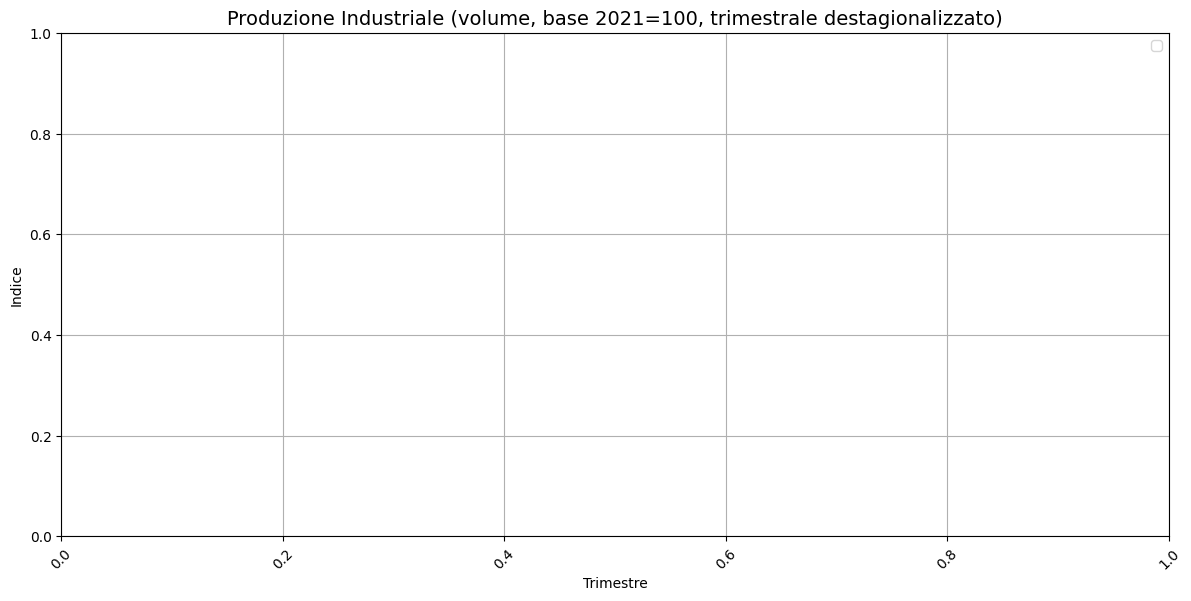

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for country in df_wide.columns:
    plt.plot(df_wide.index, df_wide[country], marker='o', label=country)

plt.title("Produzione Industriale (volume, base 2021=100, trimestrale destagionalizzato)", fontsize=14)
plt.xlabel("Trimestre")
plt.ylabel("Indice")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


## PIL Italia vs Spagna - namq_10_gdp

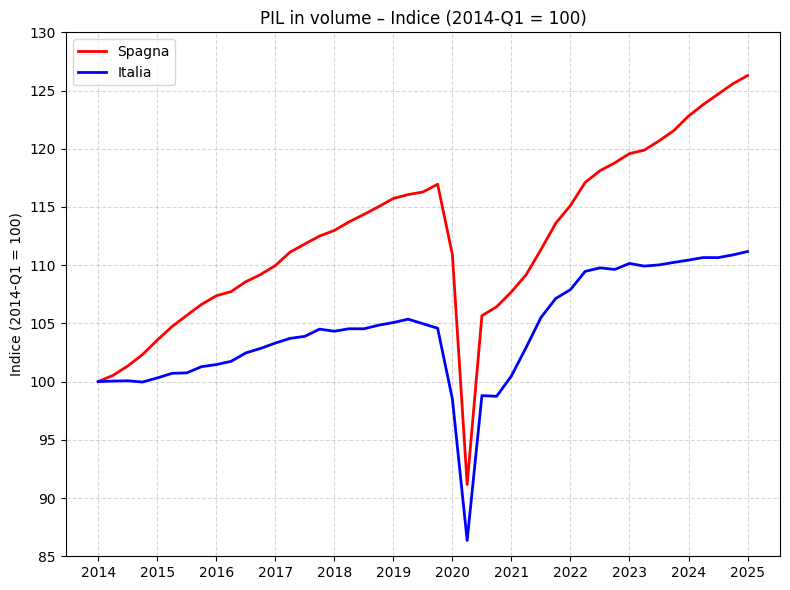

In [41]:
import re
import eurostat
import pandas as pd
import matplotlib.pyplot as plt

# 1. Scarica dati da Eurostat
df_raw = eurostat.get_data_df(
    code='namq_10_gdp',
    flags=False,
    filter_pars={
        'geo': ['IT', 'ES'],
        'unit': 'CLV10_MEUR',
        'na_item': 'B1GQ',
        's_adj': 'SCA',
        'startPeriod': '2014-Q1',
        'endPeriod': '2025-Q1'
    }
)

# 2. Rinomina colonne
df_raw = df_raw.rename(columns={'geo\\TIME_PERIOD': 'geo'})
period_cols = [c for c in df_raw.columns if re.match(r'^\d{4}-Q[1-4]$', c)]
df_tmp = df_raw[['geo'] + period_cols]

# 3. Long → Wide
df_long = df_tmp.melt(id_vars='geo', var_name='time', value_name='value')
df_long['value'] = pd.to_numeric(df_long['value'], errors='coerce')
df_pivot = df_long.pivot(index='time', columns='geo', values='value').sort_index()
df_pivot = df_pivot.dropna(how='all')

# 4. Rebase su 2014-Q1 = 100
base = df_pivot.loc['2014-Q1']
df_index = df_pivot.div(base) * 100

# 5. Plot con asse X trimestrale, ma etichette ogni anno
x_labels = df_index.index
x_ticks = [i for i, t in enumerate(x_labels) if t.endswith('Q1')]
x_ticklabels = [t[:4] for t in x_labels if t.endswith('Q1')]

plt.figure(figsize=(8, 6))  # quadrato
plt.plot(df_index.index, df_index['ES'], color='red', linewidth=2, label='Spagna')
plt.plot(df_index.index, df_index['IT'], color='blue', linewidth=2, label='Italia')

# plt.axhline(100, color='black', linestyle='--', linewidth=0.8)
plt.ylim(85, 130)
plt.xticks(ticks=x_ticks, labels=x_ticklabels)
plt.title('PIL in volume – Indice (2014-Q1 = 100)')
plt.ylabel('Indice (2014-Q1 = 100)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()
